In [1]:
# Import modules
import os
import sys
import random
import warnings

sys.path.append('./')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

from tqdm import tqdm
from itertools import chain
from skimage import color
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [2]:
# Set some parameters，e.g., image size, file directories
IMG_WIDTH = 256
IMG_HEIGHT = 256
RGB_CHANNELS = 3
GS_CHANNELS = 1
# TRAIN_PATH = '.../trainset/images/'
# TEST_PATH = '.../testset/images/'
# TRAINMS_PATH = '.../trainset/masks/'
# TESTMS_PATH = '.../testset/masks_real/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
# Get train and test IDs
train_ids = [i[:-4] for i in next(os.walk(TRAIN_PATH))[2]]  # 1120
test_ids = [i[:-4] for i in next(os.walk(TEST_PATH))[2]]   # 176

In [4]:
len(train_ids),len(test_ids)

(1120, 176)

In [5]:
# Prepare the dataset

def data_generator(train_ids,test_ids):
    # get the training images and masks and resize them
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, GS_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    
    print('Getting and resizing train images and masks ...')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        img = imread(TRAIN_PATH+id_+'.png')
        img = resize(img,(IMG_HEIGHT,IMG_WIDTH),mode='constant',preserve_range=True)
        #img = color.rgb2gray(img)
        img = np.expand_dims(img, axis=2) # (256, 256, 1)
        X_train[n] = img
#         mask = np.zeros((IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool_)
        mask = imread(TRAINMS_PATH+id_+'.png')
        mask = color.rgb2gray(mask)
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True)
        mask = np.expand_dims(mask, axis =2) # (256, 256, 1)
#         mask = np.maximum(mask,mask_)
        Y_train[n] = mask
    
    # get the test images and resize them
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, GS_CHANNELS), dtype=np.uint8)
    Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    sizes_test = []
    print('Getting and resizing test images ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(test_ids),total=len(test_ids)):
        img = imread(TEST_PATH + id_ + '.png')
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        #img = color.rgb2gray(img)
        img = np.expand_dims(img, axis=2)
        X_test[n] = img
        
        mask = imread(TESTMS_PATH+id_+'.png')
        mask = color.rgb2gray(mask)
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True)
        mask = np.expand_dims(mask, axis =2)
#         mask = np.maximum(mask,mask_)
        Y_test[n] = mask
  
    print('Data Generate Done!')
    return X_train, Y_train, X_test, Y_test, sizes_test

X_train, Y_train, X_test, Y_test, sizes_test = data_generator(train_ids,test_ids)
print("Shape of X_train: " + str(X_train.shape))
print("Shape of X_test: " + str(X_test.shape))
print("Shape of Y_train: " + str(Y_train.shape))

Getting and resizing train images and masks ...


100%|██████████| 1120/1120 [01:23<00:00, 13.34it/s]

Getting and resizing test images ... 



100%|██████████| 176/176 [00:13<00:00, 13.48it/s]

Data Generate Done!
Shape of X_train: (1120, 256, 256, 1)
Shape of X_test: (176, 256, 256, 1)
Shape of Y_train: (1120, 256, 256, 1)


In [10]:
#to save it
import pickle as pkl
# with open(".../trainset/train.pkl", "wb") as f:
#     pkl.dump([X_train, Y_train, X_test, Y_test], f)

In [14]:
#to load it
with open(".../trainset/train.pkl", "rb") as f:
    X_train, Y_train, X_test, Y_test = pkl.load(f)

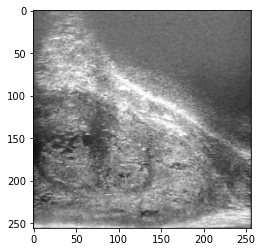

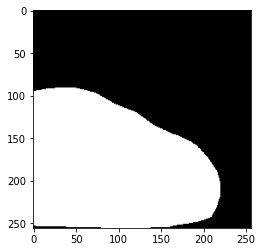

In [16]:
# Check the data

ix = random.randint(0, len(train_ids))
plt.imshow(np.squeeze(X_train[ix]), cmap='gray')
plt.show()
plt.imshow(np.squeeze(Y_train[ix]), cmap='gray')
plt.show()

In [17]:
# Definiation of metrics

def dice_coef(y_true, y_pred,smooth=1):
    y_true_f = y_true
    y_pred_f = y_pred
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    union = K.sum(y_true_f,-1) + K.sum(y_pred_f,-1) - intersection
    return (intersection + smooth) / ( union + smooth)

In [18]:
# Build the Unet model
def UNetModel(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    # Contracting path
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    # Bottleneck layer
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Dropout(0.1) (c5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    # Expanding layer
    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou_coef])
    return model

model = UNetModel(IMG_HEIGHT,IMG_WIDTH,GS_CHANNELS)

In [ ]:
#model.summary()

In [19]:
def iou_loss_plot(history):
    # summarize history for accuracy
    plt.plot(history.history['iou_coef'])
    plt.plot(history.history['val_iou_coef'])
    plt.title('model IoU')
    plt.ylabel('IoU percentage')
    plt.xlabel('epoch')
    plt.legend(['training','validation'])
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training','validation'])
    plt.show()

2022-10-17 21:15:18.971492: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-17 21:15:20.991383: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-10-17 21:15:22.228104: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2022-10-17 21:15:22.276258: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


32/32 [==============================] - 16s 207ms/step - loss: 0.6841 - iou_coef: 0.2724 - val_loss: 0.6648 - val_iou_coef: 0.2638

Epoch 00001: val_loss improved from inf to 0.66480, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-gs.hdf5
Epoch 2/100
32/32 [==============================] - 3s 79ms/step - loss: 0.7058 - iou_coef: 0.2757 - val_loss: 0.6599 - val_iou_coef: 0.2631

Epoch 00002: val_loss improved from 0.66480 to 0.65994, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-gs.hdf5
Epoch 3/100
32/32 [==============================] - 2s 78ms/step - loss: 0.5594 - iou_coef: 0.3746 - val_loss: 0.5292 - val_iou_coef: 0.3008

Epoch 00003: val_loss improved from 0.65994 to 0.52923, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-gs.hdf5
Epoch 4/100
32/32 [==============================] - 2s 78ms/step - loss: 0.4370 - iou_coef: 0.4804 - val_loss: 0.3671 - val_iou_coef: 0.5008

Epoch 00004: val_loss improved fro

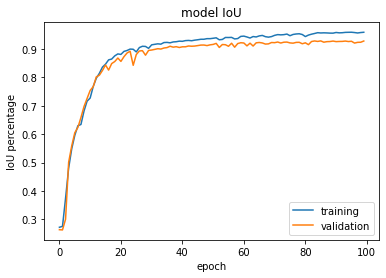

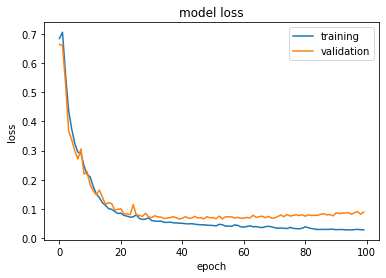

In [20]:
# fit the model
def model_fit(X_train,Y_train,model_name,epochs,batch_size,validation_split):
#     earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    history = model.fit(X_train,Y_train,validation_split=validation_split,
                       batch_size=batch_size,epochs=epochs,
                       callbacks=[checkpointer])
    iou_loss_plot(history)
    #print(history.history.keys())

model_name = '.../trainset/best-model-UCLA-UF-gs.hdf5'

epochs = 100
batch_size = 32
validation_split = 0.1
model_fit(X_train,Y_train,model_name,epochs,batch_size,validation_split)

In [21]:
# Prediction

model = load_model('.../trainset/best-model-UCLA-UF-gs.hdf5', custom_objects={'iou_coef': iou_coef})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# binomial
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# upsampling to revert to original size
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test_t[i]),
                                      (sizes_test[i][0], sizes_test[i][1]),
                                      mode='constant', preserve_range=True))


6/6 [==============================] - 0s 12ms/step


In [22]:
# Evaluation
# Get trainset IOUs

train_ious = []
for i in range(preds_train_t.shape[0]):
    intersection = np.sum(Y_train[i].astype(np.uint8) * preds_train_t[i])
    union = np.sum(Y_train[i].astype(np.uint8)) + np.sum(preds_train_t[i]) - intersection
    train_ious.append(intersection / union)
print(len(train_ious))
np_train = np.array(train_ious)
right_trainsum = np.sum((np_train>0.5).astype(np.uint8))
print(right_trainsum/len(train_ious))
print(np.median(np.array(train_ious)))
print(np.percentile(np.array(train_ious),75))
print(np.percentile(np.array(train_ious),25))


1008
1.0
0.9531370126783565
0.9661989373425756
0.9350905285005043


In [23]:
#total IOU for train set

intersection = np.sum(Y_train.astype(np.uint8)[:1008]*preds_train_t)
union = np.sum(Y_train.astype(np.uint8)[:1008])+np.sum(preds_train_t)-intersection
print(intersection/union)

0.950522911399283


In [24]:
# Get valid set IOU

val_ious = []
for i in range(preds_val_t.shape[0]):
    intersection = np.sum(Y_train[i+int(Y_train.shape[0]*0.9)].astype(np.uint8) * preds_val_t[i])
    union = np.sum(Y_train[i+int(Y_train.shape[0]*0.9)].astype(np.uint8)) + np.sum(preds_val_t[i]) - intersection
    val_ious.append(intersection / union)
print(len(val_ious))
np_val = np.array(val_ious)
right_valsum = np.sum((np_val>0.5).astype(np.uint8))
print(right_valsum/len(val_ious))
print(np.median(np.array(val_ious)))
print(np.percentile(np.array(val_ious),75))
print(np.percentile(np.array(val_ious),25))

112
0.9821428571428571
0.9434547897930712
0.9601034979384977
0.901108335810797


In [25]:
# Total IOU for valid set

intersection = np.sum(Y_train.astype(np.uint8)[1008:]*preds_val_t)
union = np.sum(Y_train.astype(np.uint8)[1008:])+np.sum(preds_val_t)-intersection
print(intersection/union)

0.9317579376462544


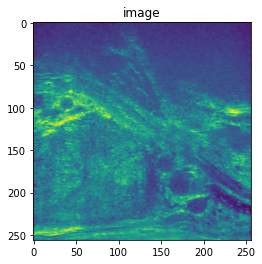

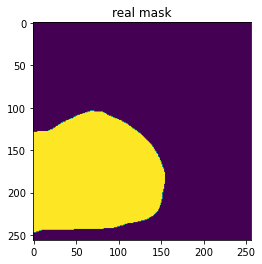

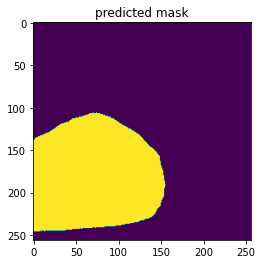

0.9678168546781686


In [27]:
# Check the real and predicted masks
ix = random.randint(0, len(preds_train_t))
plt.figure()
plt.title("image")
plt.imshow(np.squeeze(X_train[ix]))
plt.show()
plt.title("real mask")
plt.imshow(np.squeeze(Y_train[ix]))# 128*128*1
plt.show()
plt.title("predicted mask")
plt.imshow(np.squeeze(preds_train_t[ix])) # 128*128*1
plt.show()
intersection = np.sum(Y_train[ix].astype(np.uint8) * preds_train_t[ix])
union = np.sum(Y_train[ix].astype(np.uint8)) + np.sum(preds_train_t[ix]) - intersection
print(intersection/union)

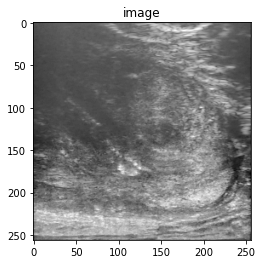

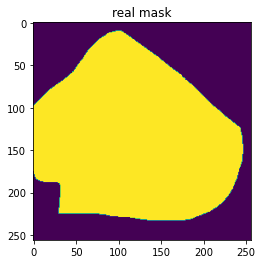

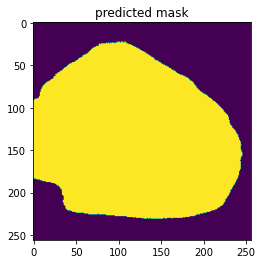

0.9446095181498539


In [29]:
# Check the real and predicted masks
ix = random.randint(0, len(preds_train_t))
plt.figure()
plt.title("image")
plt.imshow(np.squeeze(X_train[ix]),cmap='gray')
plt.show()
plt.title("real mask")
plt.imshow(np.squeeze(Y_train[ix]))# 128*128*1
plt.show()
plt.title("predicted mask")
plt.imshow(np.squeeze(preds_train_t[ix])) # 128*128*1
plt.show()
intersection = np.sum(Y_train[ix].astype(np.uint8) * preds_train_t[ix])
union = np.sum(Y_train[ix].astype(np.uint8)) + np.sum(preds_train_t[ix]) - intersection
print(intersection/union)

In [30]:
# Load testset images
X_test_unsampled = []
for n, id_ in tqdm(enumerate(test_ids),total=len(test_ids)):
    img = imread(TEST_PATH + id_ + '.png')
        
    X_test_unsampled.append(img)


100%|██████████| 176/176 [00:01<00:00, 89.23it/s]


In [32]:
# masks_pred Save the predictive masks
# *********************************************************** Save files ***********************************
for n,id_ in tqdm(enumerate(test_ids),total=len(test_ids)):
    imsave('.../testset/mask_pred_256gs/'+id_+'.png',preds_test_upsampled[n])    


  0%|          | 0/176 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  1%|          | 2/176 [00:00<00:09, 17.98it/s]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  3%|▎         | 5/176 [00:00<00:08, 20.76it/s]Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to u

0.8513807255816241


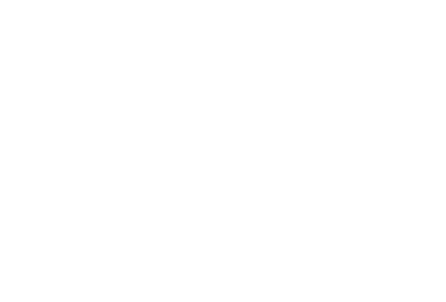

In [33]:
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import cv2

# Calculate the test set IOUs

test_img = next(os.walk('.../testset/images/'))[2]

plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
plt.axis('off')
test_iou = []
intersection_t = 0
union_t = 0
for i in range(len(test_img)):
    img1 = imread('.../testset/images/'+test_img[i])
    img1 = color.gray2rgb(img1)
    img2 = imread('.../testset/masks_real/'+test_img[i][0:-4]+'.png')
    img2 = color.rgb2gray(img2)
    #img2 = np.expand_dims(img2, axis=2)
    img3 = imread('.../testset/mask_pred_256gs/'+test_img[i][0:-4]+'.png')
    #img3 = color.rgb2gray(img3)
    #img3 = np.expand_dims(img3, axis=2)
    
    
    img2_idx_modified = img2[:,:] > 0
    img2[img2_idx_modified] = 1

    img3_idx_modified = img3[:,:] > 0
    img3[img3_idx_modified] = 1
    
    intersection_t += np.sum(img2*img3)
    union_t += np.sum(img2)+np.sum(img3)-np.sum(img2*img3)


    intersection = np.sum(img2 * img3)
    union = np.sum(img2) + np.sum(img3) - intersection
    index_iou = [test_img[i],intersection / union]
    test_iou.append(index_iou)
    
    img2_idx_modified = img2[:,:] > 0
    img2[img2_idx_modified] = 255

    img3_idx_modified = img3[:,:] > 0
    img3[img3_idx_modified] = 255
    
    img2 = np.expand_dims(img2,axis=-1)
    img2 = np.concatenate((img2,img2,img2),axis=-1)
    img2 = img2.astype(np.uint8)
    
    img3 = np.expand_dims(img3,axis=-1)
    img3 = np.concatenate((img3,img3,img3),axis=-1)
    img3 = img3.astype(np.uint8)
    
    dst_real = cv2.addWeighted(img1,1,img2,0.25,0)
    dst = cv2.addWeighted(img1,1,img3,0.25,0)
    
total_iou = intersection_t/union_t
print(total_iou)

In [34]:
# Calculate the median IOU of test set
df_testiou = pd.DataFrame(test_iou,columns=['file_name','IoU'])
# df_testiou.sort_values(['IoU'])
print(df_testiou['IoU'].median())
print(df_testiou['IoU'].quantile(0.75))
print(df_testiou['IoU'].quantile(0.25))

0.8626584791643022
0.8877496499388982
0.8209917335019081


In [35]:
# Calculate the precise
np_iou = np.array(test_iou)
right_sum = np.sum((np_iou[:,1].astype(float)>0.5).astype(np.uint8))
print(right_sum/len(test_iou))

1.0


In [38]:
# save train iou values to csv file
np.savetxt(".../testset/gs-train-ious.csv", 
           train_ious,
           delimiter =", ", 
           fmt ='% s')

[Text(0, 0, 'Trainset(1008)'),
 Text(1, 0, 'Validset(112)'),
 Text(2, 0, 'Testset(176)')]

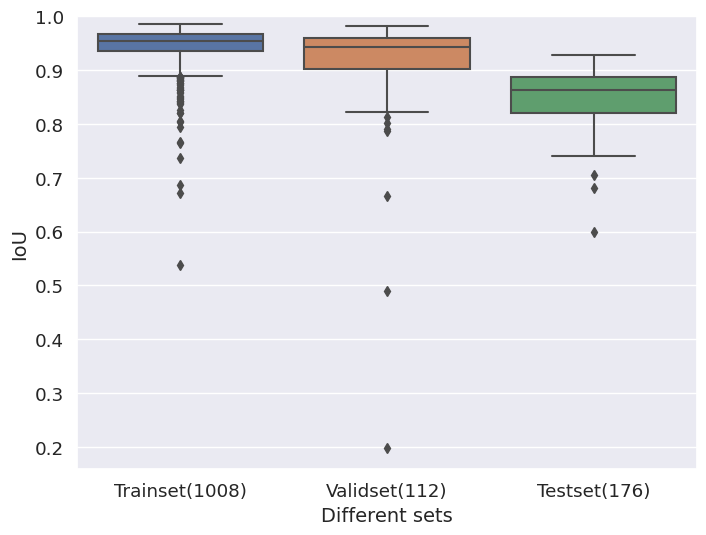

In [41]:
import seaborn as sns

# Plot the distribution of IOUs in three groups
plt.figure(num=0,figsize=(8,6),dpi=100)
sns.set(font_scale = 1.2)
g = sns.boxplot(data=[train_ious,val_ious,df_testiou['IoU']])
g.set(ylim=(None, 1))

plt.ylabel('IoU',{'size':14})
plt.xlabel('Different sets',{'size':14})
g.set_xticklabels(['Trainset(1008)','Validset(112)','Testset(176)']) 
#plt.savefig('.../figures/IoU_dist_{}.png'.format(epochs),dpi=100)

In [22]:
# cross validation
from sklearn.model_selection import KFold

Start KFold number 1 from 10
Split train:  1166 1166
Split valid:  130 130


2022-10-18 11:25:21.184507: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-18 11:25:23.094542: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-10-18 11:25:24.503637: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2022-10-18 11:25:24.584535: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


37/37 [==============================] - 18s 229ms/step - loss: 0.6854 - iou_coef: 0.2777 - val_loss: 0.6636 - val_iou_coef: 0.2896

Epoch 00001: val_loss improved from inf to 0.66359, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 2/100
37/37 [==============================] - 3s 77ms/step - loss: 0.6707 - iou_coef: 0.2950 - val_loss: 0.6651 - val_iou_coef: 0.3350

Epoch 00002: val_loss did not improve from 0.66359
Epoch 3/100
37/37 [==============================] - 3s 76ms/step - loss: 0.6643 - iou_coef: 0.3015 - val_loss: 0.6361 - val_iou_coef: 0.2888

Epoch 00003: val_loss improved from 0.66359 to 0.63607, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 4/100
37/37 [==============================] - 3s 76ms/step - loss: 0.5638 - iou_coef: 0.3208 - val_loss: 0.5237 - val_iou_coef: 0.3504

Epoch 00004: val_loss improved from 0.63607 to 0.52367, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model

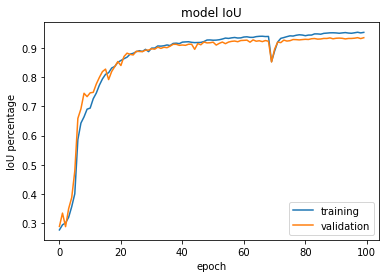

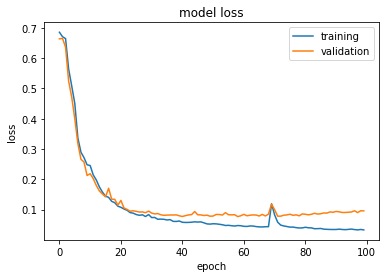

Start KFold number 2 from 10
Split train:  1166 1166
Split valid:  130 130
Epoch 1/100
37/37 [==============================] - 4s 84ms/step - loss: 0.6878 - iou_coef: 0.2829 - val_loss: 0.6884 - val_iou_coef: 0.2818

Epoch 00001: val_loss improved from inf to 0.68843, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 2/100
37/37 [==============================] - 3s 79ms/step - loss: 0.6873 - iou_coef: 0.2817 - val_loss: 0.6985 - val_iou_coef: 0.2626

Epoch 00002: val_loss did not improve from 0.68843
Epoch 3/100
37/37 [==============================] - 3s 79ms/step - loss: 0.6813 - iou_coef: 0.2622 - val_loss: 0.6861 - val_iou_coef: 0.2888

Epoch 00003: val_loss improved from 0.68843 to 0.68610, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 4/100
37/37 [==============================] - 3s 79ms/step - loss: 0.6718 - iou_coef: 0.2936 - val_loss: 0.6476 - val_iou_coef: 0.3165

Epoch 00004: val_loss improved fro

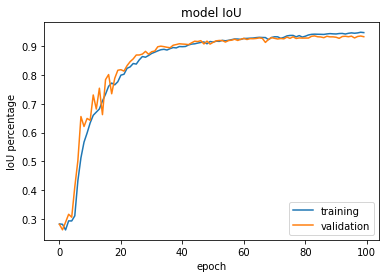

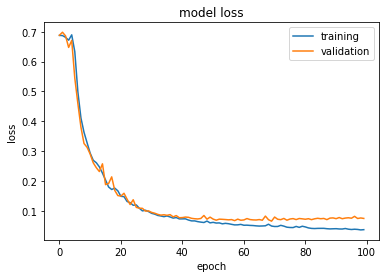

Start KFold number 3 from 10
Split train:  1166 1166
Split valid:  130 130
Epoch 1/100
37/37 [==============================] - 4s 85ms/step - loss: 0.6815 - iou_coef: 0.2711 - val_loss: 0.6522 - val_iou_coef: 0.3096

Epoch 00001: val_loss improved from inf to 0.65224, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 2/100
37/37 [==============================] - 3s 79ms/step - loss: 0.5736 - iou_coef: 0.3490 - val_loss: 0.4714 - val_iou_coef: 0.5440

Epoch 00002: val_loss improved from 0.65224 to 0.47143, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 3/100
37/37 [==============================] - 3s 79ms/step - loss: 0.3921 - iou_coef: 0.5354 - val_loss: 0.4263 - val_iou_coef: 0.5469

Epoch 00003: val_loss improved from 0.47143 to 0.42629, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 4/100
37/37 [==============================] - 3s 79ms/step - loss: 0.3219 - iou_coef:

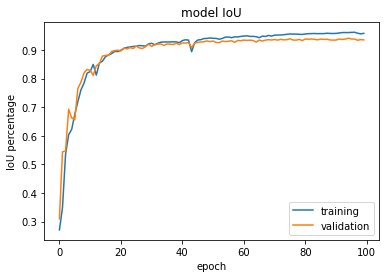

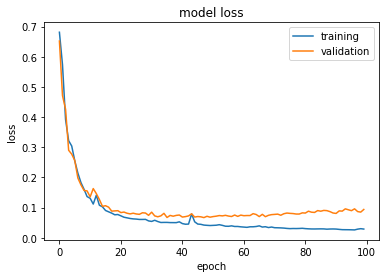

Start KFold number 4 from 10
Split train:  1166 1166
Split valid:  130 130
Epoch 1/100
37/37 [==============================] - 4s 86ms/step - loss: 0.6833 - iou_coef: 0.2714 - val_loss: 0.6703 - val_iou_coef: 0.2795

Epoch 00001: val_loss improved from inf to 0.67028, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 2/100
37/37 [==============================] - 3s 79ms/step - loss: 0.6149 - iou_coef: 0.3081 - val_loss: 0.5592 - val_iou_coef: 0.3522

Epoch 00002: val_loss improved from 0.67028 to 0.55918, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 3/100
37/37 [==============================] - 3s 79ms/step - loss: 0.5202 - iou_coef: 0.3841 - val_loss: 0.4098 - val_iou_coef: 0.5094

Epoch 00003: val_loss improved from 0.55918 to 0.40980, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 4/100
37/37 [==============================] - 3s 79ms/step - loss: 0.3802 - iou_coef:

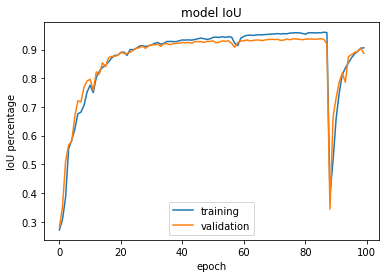

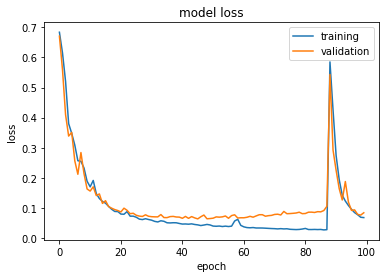

Start KFold number 5 from 10
Split train:  1166 1166
Split valid:  130 130
Epoch 1/100
37/37 [==============================] - 4s 85ms/step - loss: 0.6830 - iou_coef: 0.2743 - val_loss: 0.6765 - val_iou_coef: 0.3047

Epoch 00001: val_loss improved from inf to 0.67652, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 2/100
37/37 [==============================] - 3s 79ms/step - loss: 0.5947 - iou_coef: 0.3417 - val_loss: 0.4990 - val_iou_coef: 0.3597

Epoch 00002: val_loss improved from 0.67652 to 0.49903, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 3/100
37/37 [==============================] - 3s 79ms/step - loss: 0.4523 - iou_coef: 0.4428 - val_loss: 0.3443 - val_iou_coef: 0.5920

Epoch 00003: val_loss improved from 0.49903 to 0.34433, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 4/100
37/37 [==============================] - 3s 79ms/step - loss: 0.3419 - iou_coef:

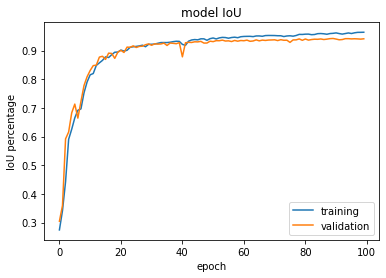

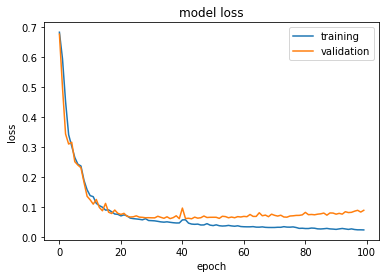

Start KFold number 6 from 10
Split train:  1166 1166
Split valid:  130 130
Epoch 1/100
37/37 [==============================] - 4s 85ms/step - loss: 0.6854 - iou_coef: 0.2791 - val_loss: 0.6588 - val_iou_coef: 0.2635

Epoch 00001: val_loss improved from inf to 0.65882, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 2/100
37/37 [==============================] - 3s 79ms/step - loss: 0.6978 - iou_coef: 0.2839 - val_loss: 0.6838 - val_iou_coef: 0.2986

Epoch 00002: val_loss did not improve from 0.65882
Epoch 3/100
37/37 [==============================] - 3s 79ms/step - loss: 0.7034 - iou_coef: 0.2763 - val_loss: 0.6810 - val_iou_coef: 0.2941

Epoch 00003: val_loss did not improve from 0.65882
Epoch 4/100
37/37 [==============================] - 3s 79ms/step - loss: 0.6694 - iou_coef: 0.3024 - val_loss: 0.6445 - val_iou_coef: 0.3408

Epoch 00004: val_loss improved from 0.65882 to 0.64445, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model

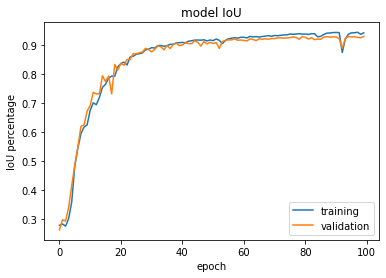

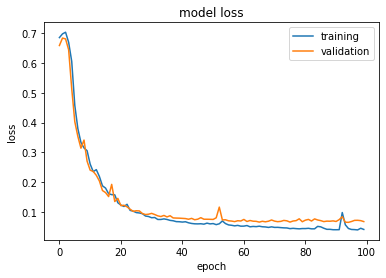

Start KFold number 7 from 10
Split train:  1167 1167
Split valid:  129 129
Epoch 1/100
37/37 [==============================] - 9s 231ms/step - loss: 0.7243 - iou_coef: 0.2716 - val_loss: 0.6711 - val_iou_coef: 0.2958

Epoch 00001: val_loss improved from inf to 0.67107, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 2/100
37/37 [==============================] - 3s 79ms/step - loss: 0.6300 - iou_coef: 0.3109 - val_loss: 0.9705 - val_iou_coef: 0.1152

Epoch 00002: val_loss did not improve from 0.67107
Epoch 3/100
37/37 [==============================] - 3s 78ms/step - loss: 0.5708 - iou_coef: 0.3598 - val_loss: 0.5193 - val_iou_coef: 0.5643

Epoch 00003: val_loss improved from 0.67107 to 0.51933, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 4/100
37/37 [==============================] - 3s 78ms/step - loss: 0.4215 - iou_coef: 0.5118 - val_loss: 0.3718 - val_iou_coef: 0.6033

Epoch 00004: val_loss improved fr

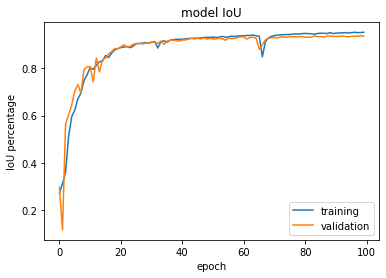

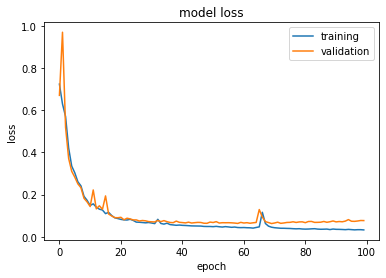

Start KFold number 8 from 10
Split train:  1167 1167
Split valid:  129 129
Epoch 1/100
37/37 [==============================] - 4s 84ms/step - loss: 0.6863 - iou_coef: 0.2829 - val_loss: 0.6778 - val_iou_coef: 0.2703

Epoch 00001: val_loss improved from inf to 0.67784, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 2/100
37/37 [==============================] - 3s 79ms/step - loss: 0.6413 - iou_coef: 0.2962 - val_loss: 0.5429 - val_iou_coef: 0.3360

Epoch 00002: val_loss improved from 0.67784 to 0.54293, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 3/100
37/37 [==============================] - 3s 80ms/step - loss: 0.4634 - iou_coef: 0.4634 - val_loss: 0.3708 - val_iou_coef: 0.5701

Epoch 00003: val_loss improved from 0.54293 to 0.37079, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 4/100
37/37 [==============================] - 3s 79ms/step - loss: 0.3659 - iou_coef:

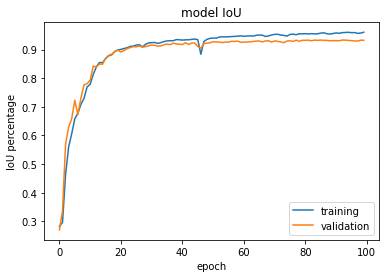

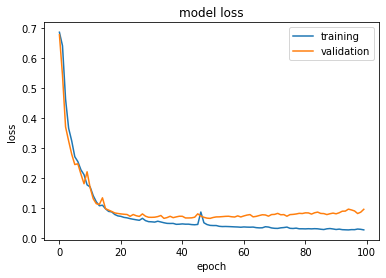

Start KFold number 9 from 10
Split train:  1167 1167
Split valid:  129 129
Epoch 1/100
37/37 [==============================] - 4s 85ms/step - loss: 0.6809 - iou_coef: 0.2813 - val_loss: 0.6150 - val_iou_coef: 0.2944

Epoch 00001: val_loss improved from inf to 0.61502, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 2/100
37/37 [==============================] - 3s 79ms/step - loss: 0.6760 - iou_coef: 0.2943 - val_loss: 0.7915 - val_iou_coef: 0.1702

Epoch 00002: val_loss did not improve from 0.61502
Epoch 3/100
37/37 [==============================] - 3s 79ms/step - loss: 0.5650 - iou_coef: 0.3797 - val_loss: 0.4859 - val_iou_coef: 0.3847

Epoch 00003: val_loss improved from 0.61502 to 0.48590, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 4/100
37/37 [==============================] - 3s 79ms/step - loss: 0.4645 - iou_coef: 0.4641 - val_loss: 0.3606 - val_iou_coef: 0.5853

Epoch 00004: val_loss improved fro

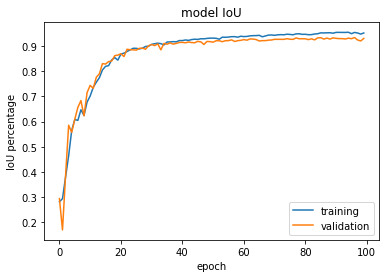

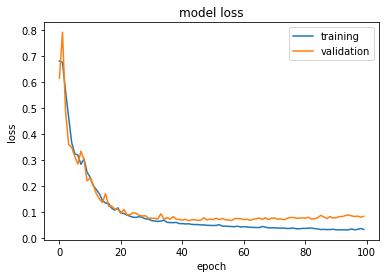

Start KFold number 10 from 10
Split train:  1167 1167
Split valid:  129 129
Epoch 1/100
37/37 [==============================] - 4s 85ms/step - loss: 0.6797 - iou_coef: 0.2693 - val_loss: 0.6553 - val_iou_coef: 0.2968

Epoch 00001: val_loss improved from inf to 0.65527, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 2/100
37/37 [==============================] - 3s 79ms/step - loss: 0.6506 - iou_coef: 0.2960 - val_loss: 0.5828 - val_iou_coef: 0.3793

Epoch 00002: val_loss improved from 0.65527 to 0.58281, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 3/100
37/37 [==============================] - 3s 79ms/step - loss: 0.5735 - iou_coef: 0.3456 - val_loss: 0.5246 - val_iou_coef: 0.3671

Epoch 00003: val_loss improved from 0.58281 to 0.52458, saving model to cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5
Epoch 4/100
37/37 [==============================] - 3s 79ms/step - loss: 0.4528 - iou_coef

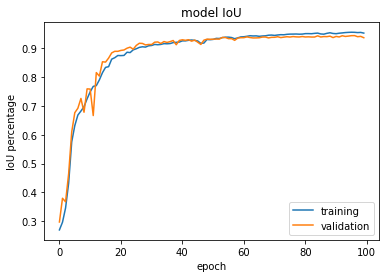

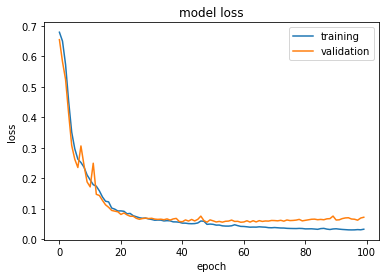

IoU train independent median:  0.9406139995665932  IQ 0.9386581113872035 - 0.9425368108561981
Accuracy independet median:  0.9923076923076923  IQ 0.9922480620155039 - 1.0
IoU_0.9424990592087102_folds_10_ep_100


In [23]:
num_fold = 0
sum_score = 0
models = []
nfolds = 10
model_name = 'cota_blue_wenbin/UNet-PCa/trainset-0/best-model-UCLA-UF-cv.hdf5'
epochs = 100
batch_size = 32
yfull_train = dict()
scores = []
accus = []

def cv_iou(y_valid, pred_valid):
    pred_valid = (pred_valid > 0.5).astype(np.uint8)
    intersection = np.sum(np.abs(y_valid * pred_valid))
    union = np.sum(y_valid) + np.sum(pred_valid) - intersection
    return (intersection+1) / (union+1)

def cv_accu(y_valid, pred_valid):
    accu_bi = []
    for i in range(len(y_valid)):
        s_iou = cv_iou(y_valid[i], pred_valid[i])
        accu_bi.append((s_iou > 0.5).astype(np.uint(8)))
    return sum(accu_bi)/len(accu_bi)
    

kf = KFold(n_splits=nfolds, shuffle=True, random_state=seed)

total_ids = train_ids + test_ids
X_total = np.concatenate((X_train, X_test), axis=0)
Y_total = np.concatenate((Y_train, Y_test), axis=0)

for train_index, valid_index in kf.split(total_ids):
    model = UNetModel(IMG_HEIGHT,IMG_WIDTH,GS_CHANNELS) 
    cvx_train = X_total[train_index]
    cvy_train = Y_total[train_index]
    cvx_valid = X_total[valid_index]
    cvy_valid = Y_total[valid_index]
  
    num_fold += 1
    print("Start KFold number {} from {}".format(num_fold, nfolds))
    print("Split train: ", len(cvx_train), len(cvy_train))
    print("Split valid: ", len(cvx_valid), len(cvy_valid))
  
    #earlystopper = EarlyStopping(patience=15, verbose=1)
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)

    history = model.fit(cvx_train, cvy_train, batch_size=batch_size, epochs=epochs,
           shuffle=True, verbose=1, validation_data=(cvx_valid, cvy_valid),
           callbacks=[checkpointer])

    pred_valid = model.predict(cvx_valid, batch_size=batch_size, verbose=2)
    score = cv_iou(cvy_valid, pred_valid)
    accu = cv_accu(cvy_valid, pred_valid)
    print("Score iou_coef: ", score)
    print("Accuracy: ", accus)

    iou_loss_plot(history)

    scores.append(score)
    accus.append(accu)
    sum_score += score * len(valid_index)

    # Store valid predictions
    for i in range(len(valid_index)):
        yfull_train[valid_index[i]] = pred_valid[i] 
    models.append(model)  
# socre = np.median(scores)
# accu = np.median(accus)
print("IoU train independent median: ", np.median(scores), " IQ", np.quantile(scores, 0.25), "-", np.quantile(scores, 0.75))
print("Accuracy independet median: ", np.median(accus), " IQ", np.quantile(accus, 0.25), "-", np.quantile(accus, 0.75))
info_string = "IoU_" + str(score) + "_folds_" + str(nfolds) + "_ep_" + str(epochs)
print (info_string)


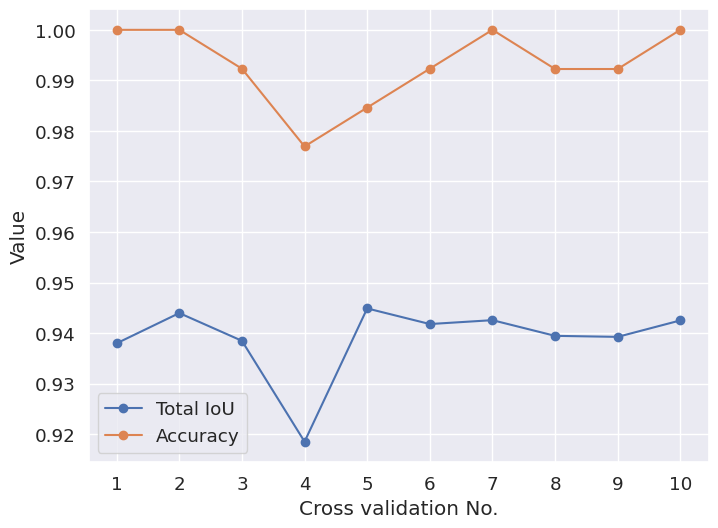

In [30]:
# Plot the results of cross validation
plt.figure(figsize=(8,6),dpi=100)
x_axis = np.array(range(nfolds)) + 1 # decide the folder number 10
plt.plot(x_axis, scores, marker="o", label="Total IoU")
plt.plot(x_axis, accus, marker="o", label="Accuracy")
plt.xticks(x_axis)
plt.xlabel("Cross validation No.")
#plt.yticks(np.linspace(0.9,1,11))
plt.ylabel("Value")
plt.legend()
#plt.savefig('.../figures/Cross_val_{}.png'.format(epochs))
plt.show()